In [139]:
import numpy as np
import pandas as pd
import pickle
import matplotlib
import scipy
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from scipy import stats
pd.options.mode.chained_assignment = None  # default='warn'

In [13]:
# trims a dataframe of outliers of the conditional distribution of y given x
def trimDF(df,x,y,percentiles,bins,binwidth):
    for i in range (len(bins)-1):
        data = df.loc[abs(df[x]-bins[i])<binwidth[i]]
        if not data.empty:
            df = df.drop(data.loc[(data[y]<np.percentile(data[y], percentiles[0]))].index.values)
            df = df.drop(data.loc[(data[y]>np.percentile(data[y], percentiles[1]))].index.values)
    return df



In [14]:
def scaleColumns(df, cols_to_scale):
    for col in cols_to_scale:
        df[col] = pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame(dfTest[col])),columns=[col])
    return df

In [121]:
# sets up a Sobol sampling grid and finds one match in df within a distance of each Sobol grid sample
def sobolSampler(df,featureColumns,leafSize,randSeed,numDim,numSamPerDim):
    sobel = scipy.stats.qmc.Sobol(len(featureColumns),seed=randSeed).random_base2(m=np.uint8(np.ceil(np.log2(np.power(numSamPerDim,numDim)))))
    sobelTree = scipy.spatial.KDTree(sobel, leafsize=leafSize, compact_nodes=True, copy_data=False, balanced_tree=True, boxsize=None)
    sampleTree = scipy.spatial.KDTree(scaledSample[featureColumns], leafsize=leafSize, compact_nodes=True, copy_data=False, balanced_tree=True, boxsize=None)
    indexes = sobelTree.query_ball_tree(sampleTree, r=0.5*numDim/numSamPerDim,p=1)
    indexes = [ele for ele in indexes if ele != []]
    index = []
    newsamples  = scaledSample.iloc[0:1]
    for i in range(len(indexes)):
        index.append(indexes[i][0])
    index = list(set(index))
    
    return scaledSample.iloc[index]


In [88]:
# does lars regression , displays path and returns results
def showLarsPath(X,y):
    
    alphas, active, coefs = linear_model.lars_path(X=X,y=y, method="lars", verbose=True)
    xx = np.sum(np.abs(coefs.T), axis=1)
    xx /= xx[-1]
    plt.plot(xx, coefs.T)
    ymin, ymax = plt.ylim()
    plt.vlines(xx, ymin, ymax, linestyle="dashed")
    plt.xlabel("|coef| / max|coef|")
    plt.ylabel("Coefficients")
    plt.title("LASSO Path")
    plt.axis("tight")
    plt.show()
    
    return alphas, active, coefs

In [3]:
file_name = ['LUTinputLC0XB36cal', 'LUTinputLC0XB45cal','LUTinputMOD09cal' ,'LUTinputLC0XLatcal', \
             'LUTinputLC0XLoncal','LUToutputLC0Xcal','YearLC0Xcal','MonthLC0Xcal', \
             'DayLC0Xcal','PathLC0Xcal','RowLC0Xcal']

dataset = []
DataList = []
count = 0

for name in file_name:
    dataset.append(f'/home/richard_fernandes/LandsatMODIS/{name}')

for name_dataset in dataset:
    with open(f'{name_dataset}', 'rb') as fp1:
        objs = []
        while 1:
            try:
                objs.append(pickle.load(fp1))
            except EOFError:
                break
        DataList = [item for sublist in objs for item in sublist]
        
    if count == 0:
        LUTB36_list = DataList
    elif count == 1:
        LUTB45_list = DataList
    elif count == 2:
        LUTMOD09_list = DataList
    elif count == 3:
        LUTLat = DataList
    elif count == 4:
        LUTLon = DataList
    elif count == 5:
        LUToutput_list = DataList
    elif count == 6:
        LUTyear = DataList
    elif count == 7:
        LUTmonth = DataList
    elif count == 8:
        LUTday = DataList
    elif count == 9:
        LUTpath = DataList
    elif count == 10:
        LUTrow = DataList
    
    count = count + 1
        
print('LUTB36_list:', len(LUTB36_list))
print('LUTB45_list:', len(LUTB45_list))
print('LUTMOD09_list:', len(LUTMOD09_list))
print('LUTLat:', len(LUTLat))
print('LUTLon:', len(LUTLon))
print('LUToutput_list:', len(LUToutput_list))
print('LUTyear:', len(LUTyear))
print('LUTmonth:', len(LUTmonth))
print('LUTday:', len(LUTday))
print('LUTpath:', len(LUTpath))
print('LUTrow:', len(LUTrow))


LUTB36_list: 6792058
LUTB45_list: 6792058
LUTMOD09_list: 6792058
LUTLat: 6792058
LUTLon: 6792058
LUToutput_list: 6792058
LUTyear: 6792058
LUTmonth: 6792058
LUTday: 6792058
LUTpath: 6792058
LUTrow: 6792058


In [4]:
# parse the LUTs into Pandas tables
LUT_Lai = np.double(np.floor(np.mod(LUToutput_list,1e2)/1e0))
LUT_LaiStdDev = np.double(np.floor(np.floor(np.mod(LUToutput_list,1e4)/1e2)))
LUT_Fpar = np.double(np.floor(np.mod(LUToutput_list,1e6))/1e4)
LUT_FparStdDev = np.double(np.floor(np.floor(np.mod(LUToutput_list,1e8)/1e6)))
LUT_satFlag = np.uint64(np.floor(np.mod(LUToutput_list,1e11))/1e8)
LUT_snowFlag = np.uint64(np.floor(np.floor(np.mod(LUToutput_list,1e14)/1e11)))
LUT_LC_Type3 = np.uint64(np.floor(np.floor(np.mod(LUToutput_list,1e16)/1e14)))



LUT_SR_B3 = np.double(np.floor(np.floor(np.mod(LUTB36_list,1e3)/1)))
LUT_SR_B4 = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e3)/1)))

LUT_SR_B5 = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e6)/1e3)))
LUT_SR_B6 = np.double(np.floor(np.floor(np.mod(LUTB36_list,1e6)/1e3)))
LUT_VIEW_ZENITH = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e8)/1e6)))
LUT_VIEW_AZIMUTH = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e11)/1e8)))
LUT_SUN_ELEVATION = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e13)/1e11)))
LUT_SUN_AZIMUTH = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e16)/1e13)))

LUT_MOD09_red = np.double(np.floor(np.floor(np.mod(LUTMOD09_list,1e4)/1)))
LUT_MOD09_NIR = np.double(np.floor(np.floor(np.mod(LUTMOD09_list,1e8)/1e4)))


In [5]:
# make pandas frame of all coded inputs
unsatDF_NA =  pd.DataFrame( {'year':LUTyear, 'month': LUTmonth, 'day': LUTday, 'path':LUTpath, 'row':LUTrow,\
                          'Lat':LUTLat, 'Lon':LUTLon, 'input36': LUTB36_list,'input45':LUTB45_list, 'inputMOD09': LUTMOD09_list, 'redMODIS': LUT_MOD09_red,'NIRMODIS': LUT_MOD09_NIR,\
                          'green':LUT_SR_B3 * 10, 'red':LUT_SR_B4 * 10, 'NIR': LUT_SR_B5 * 10, 'SWIR1': LUT_SR_B6 * 10,   \
                          'SensorZenith':LUT_VIEW_ZENITH, 'SensorAzimuth': LUT_VIEW_AZIMUTH, 'SolarZenith':LUT_SUN_ELEVATION, 'SolarAzimuth': LUT_SUN_AZIMUTH, \
                          'LC_type3': LUT_LC_Type3, 'output': LUToutput_list,'LAI': LUT_Lai, 'stdLAI': LUT_LaiStdDev, 'FAPAR': LUT_Fpar, 'stdFAPAR': LUT_FparStdDev,\
                          'LUT_satFlag': LUT_satFlag,'LUT_snowFlag': LUT_snowFlag,'LC_type3': LUT_LC_Type3}) \
               .sort_values('input36')





[Text(0.5, 0, 'NIRMODIS'), Text(0, 0.5, 'NIR')]

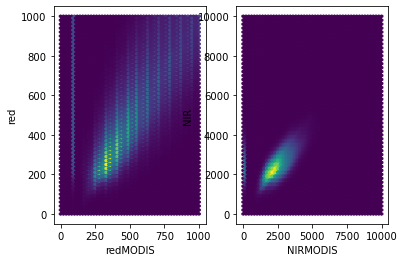

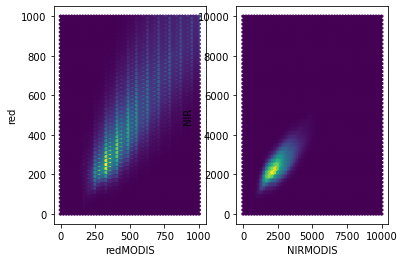

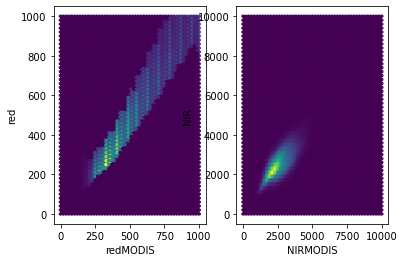

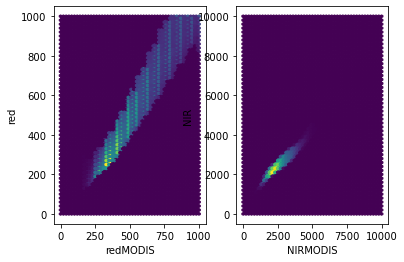

In [6]:
# trim data based on comparing Landsat and MODIS equivalents
# note we oversample the MODIS axis as we trim
# this takes some time

# histogram NDVI vs LAI
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hexbin(unsatDF_NA['redMODIS'],unsatDF_NA['red'], gridsize=(50,50), extent=(0,1000,0,1000))
ax1.set(xlabel='redMODIS', ylabel='red')
ax2.hexbin(unsatDF_NA['NIRMODIS'],unsatDF_NA['NIR'], gridsize=(50,50), extent=(0,10000,0,10000))
ax2.set(xlabel='NIRMODIS', ylabel='NIR')

# threshold based on red MODIS
trimSample = unsatDF_NA.drop(unsatDF_NA.loc[(unsatDF_NA['redMODIS']<100)].index.values)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hexbin(trimSample['redMODIS'],trimSample['red'], gridsize=(50,50), extent=(0,1000,0,1000))
ax1.set(xlabel='redMODIS', ylabel='red')
ax2.hexbin(trimSample['NIRMODIS'],trimSample['NIR'], gridsize=(50,50), extent=(0,10000,0,10000))
ax2.set(xlabel='NIRMODIS', ylabel='NIR')


# trim based on red
trimSample = trimDF(trimSample,'redMODIS','red',[10,90],np.arange(0.0,1000.0,10),np.arange(0,1000,10)*0+20)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hexbin(trimSample['redMODIS'],trimSample['red'], gridsize=(50,50), extent=(0,1000,0,1000))
ax1.set(xlabel='redMODIS', ylabel='red')
ax2.hexbin(trimSample['NIRMODIS'],trimSample['NIR'], gridsize=(50,50), extent=(0,10000,0,10000))
ax2.set(xlabel='NIRMODIS', ylabel='NIR')

#trim based on nir
trimSample = trimDF(trimSample,'NIRMODIS','NIR',[10,90],np.arange(0.0,10000.0,100),np.arange(0,10000,100)*0+200)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hexbin(trimSample['redMODIS'],trimSample['red'], gridsize=(50,50), extent=(0,1000,0,1000))
ax1.set(xlabel='redMODIS', ylabel='red')
ax2.hexbin(trimSample['NIRMODIS'],trimSample['NIR'], gridsize=(50,50), extent=(0,10000,0,10000))
ax2.set(xlabel='NIRMODIS', ylabel='NIR')


86156


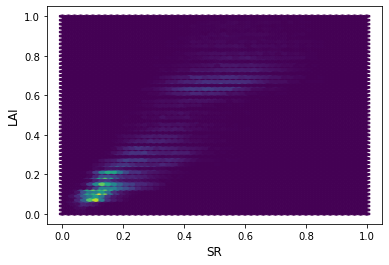

5277


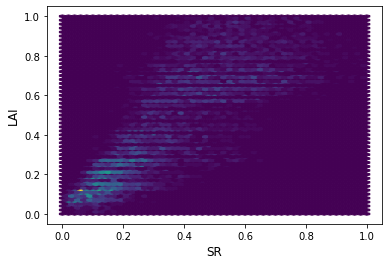

.

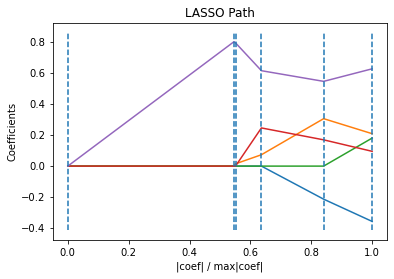

TypeError: power() takes from 2 to 3 positional arguments but 1 were given

In [129]:
# process each biome type separately
for LC_type3 in [6]: #unsatDF_NA["LC_type3"].drop_duplicates():
    #subset sample
    sample = trimSample[trimSample["LC_type3"]==LC_type3]
    print(len(sample))
    
    # add ISR and SR 
    sample['ISR'] = np.clip((sample.loc[:,"NIR"])/np.maximum(sample.loc[:,"SWIR1"],1),0,3)
    sample['SR'] = np.clip((sample.loc[:,"NIR"])/np.maximum(sample.loc[:,"red"],1),0,20)
    
    # trim based on LAI vs VIs
    # we oversample in LAI
    # fig, (ax1, ax2) = plt.subplots(1,2)
    # ax1.hexbin(sample['LAI'],sample['SR'], gridsize=(50,50), extent=(0,100,0,20))
    # ax1.set(xlabel='LAI', ylabel='SR')
    # ax2.hexbin(sample['LAI'],sample['ISR'], gridsize=(50,50), extent=(0,100,0,3))
    # ax2.set(xlabel='LAI', ylabel='ISR')
    # trimSample2 = trimDF(sample,'LAI','SR',[10,90],np.arange(0.0,100.0,10),np.arange(0,100,10)*0+10)
    # trimSample2 = trimDF(sample,'LAI','ISR',[10,90],np.arange(0.0,100.0,10),np.arange(0,100,10)*0+10)
    
    # see results 
    # fig, (ax1, ax2) = plt.subplots(1,2)
    # ax1.hexbin(trimSample2['LAI'],trimSample2['SR'], gridsize=(50,50), extent=(0,100,0,20))
    # ax1.set(xlabel='LAI', ylabel='SR')
    # ax2.hexbin(trimSample2['LAI'],trimSample2['ISR'], gridsize=(50,50), extent=(0,100,0,3))
    # ax2.set(xlabel='LAI', ylabel='ISR')
    # fig, (ax1, ax2) = plt.subplots(1,2)
    # ax1.hexbin(trimSample2['redMODIS'],trimSample2['red'], gridsize=(50,50), extent=(0,1000,0,1000))
    # ax1.set(xlabel='redMODIS', ylabel='red')
    # ax2.hexbin(trimSample2['NIRMODIS'],trimSample2['NIR'], gridsize=(50,50), extent=(0,10000,0,10000))
    # ax2.set(xlabel='NIRMODIS', ylabel='NIR')   
    
    # add a lot of VIs 
    listVI = [ 'red','NIR','SWIR1','SR','ISR']
    
    # standardize or rescale the data (probably rescale based on 1,99 %ile range since data is skewed)
    scalerSample = MinMaxScaler().fit(trimSample2)
    scaledSample = pd.DataFrame(scalerSample.transform(trimSample2),columns = trimSample2.columns, index =trimSample2.index)

    # see results
    # fig, (ax1, ax2) = plt.subplots(1,2)
    # ax1.hexbin(scaledSample['LAI'],scaledSample['SR'], gridsize=(50,50), extent=(0,1,0,1))
    # ax1.set(xlabel='LAI', ylabel='SR')
    # ax2.hexbin(scaledSample['LAI'],scaledSample['ISR'], gridsize=(50,50), extent=(0,1,0,1))
    # ax2.set(xlabel='LAI', ylabel='ISR')
    # fig, (ax1, ax2) = plt.subplots(1,2)
    # ax1.hexbin(scaledSample['redMODIS'],scaledSample['red'], gridsize=(50,50), extent=(0,1,0,1))
    # ax1.set(xlabel='redMODIS', ylabel='red')
    # ax2.hexbin(scaledSample['NIRMODIS'],scaledSample['NIR'], gridsize=(50,50), extent=(0,1,0,1))
    # ax2.set(xlabel='NIRMODIS', ylabel='NIR')  
    


    # initial data
    plt.hexbin(scaledSample['SR'],scaledSample['LAI'], gridsize=(50,50), extent=(0,1,0,1))
    plt.xlabel('SR',size = 12)
    plt.ylabel('LAI',size = 12)
    plt.show() 
    
    # do a coarse uniform subsample  VIs
    featureColumns = listVI + ['LAI']
    numDim = len(featureColumns)
    numSamPerDim = 10
    newSample  = scaledSample.iloc[0:1]
    leafSize = 10
    for i in range(1,2):
        newSample = pd.concat([newSample,sobolSampler(scaledSample,featureColumns,leafSize,randSeed,numDim,numSamPerDim)])
        print(len(newSample))   
        plt.hexbin(newSample['SR'],newSample['LAI'], gridsize=(50,50), extent=(0,1,0,1))
        plt.xlabel('SR',size = 12)
        plt.ylabel('LAI',size = 12)
        plt.show()    
    
    # do lars to select a subset of good vis (you can visualize bu using show LarsPath or actually get the model using (e.g. we use 2 so we can visualize easily) 
    alphas, active, coefs = showLarsPath(newSample[listVI].to_numpy(),newSample['LAI'].to_numpy())
    listVI = [listVI[i] for i in np.uint64(np.subtract(np.where(coefs[:,2]>0),1))[0]]
    
    # do a coarse uniform subsample with lars  VIs keeping same number of samples as before
    featureColumns = listVI + ['LAI']
    numDim = len(featureColumns)
    numSamPerDim = 30
    newSample  = scaledSample.iloc[0:1]
    leafSize = 10
    for i in range(1,2):
        newSample = pd.concat([newSample,sobolSampler(scaledSample,featureColumns,leafSize,randSeed,numDim,numSamPerDim)])
        print(len(newSample))   
        plt.hexbin(newSample['SR'],newSample['LAI'], gridsize=(50,50), extent=(0,1,0,1))
        plt.xlabel('SR',size = 12)
        plt.ylabel('LAI',size = 12)
        plt.show() 

        
    # do kmeans with only a M clusters on the lars subset and visualize
    plt.hexbin(newSample[listVI[0]],newSample[listVI[1]], gridsize=(50,50), extent=(0,1,0,1))
    plt.xlabel(listVI[0],size = 12)
    plt.ylabel(listVI[1],size = 12)
    plt.show() 
    kmeans = KMeans(n_clusters=10, random_state=0).fit(newSample[listVI])
    plt.hexbin(newSample[listVI[0]],newSample[listVI[1]], gridsize=(50,50), extent=(0,1,0,1))
    plt.scatter(kmeans.centroids_[:,0],kmeans.centroids_[:,1],c='y')
    
    # label all samples as the closest and next closest cluster 
    # for each cluster
        # find all samples that are closest or next closest to it (this prevents artifacts at cluster edges)
        # do N different fine uniform samples and for each sample
            # fit a random forest
            
# this will result in M clusters , with each cluster have N random forests
# you can try the RF offline in scikit learn and if it is reasonable then fit the in GEE by uploading the samples 

        

[[0.11843634 0.40131293]
 [0.09164798 0.66358569]
 [0.55758698 0.07281116]
 [0.11069468 0.52979686]
 [0.24891493 0.19136147]
 [0.06540179 0.82855244]
 [0.15285967 0.25712716]
 [0.79439787 0.03306432]
 [0.37290737 0.12214509]
 [0.2185507  0.35906238]]


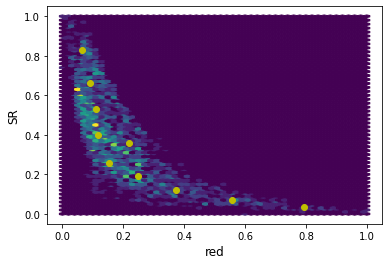

In [138]:
centroids = kmeans.cluster_centers_
print(centroids)

plt.xlabel(listVI[0],size = 12)
plt.ylabel(listVI[1],size = 12)
plt.show() 

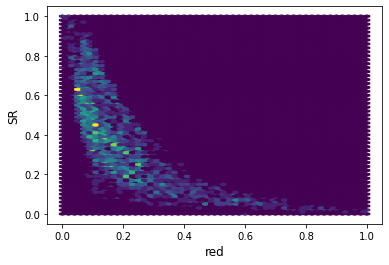

In [ ]:
# 

In [ ]:
# everything below here is just trying stuff out

In [244]:
# rescale data between zero and one to make things easier later
samples = sample[['LAI','SR','ISR']]
samples['LAI'] = (sample['LAI'] - sample['LAI'].min()) / ( sample['LAI'].max()- sample['LAI'].min())  
samples['SR'] = (sample['SR'] - sample['SR'].min()) / ( sample['SR'].max()- sample['SR'].min())  
samples['ISR'] = (sample['ISR'] - sample['ISR'].min()) / ( sample['ISR'].max()- sample['ISR'].min())  



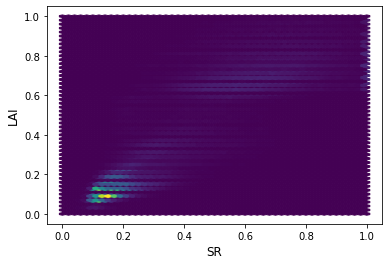

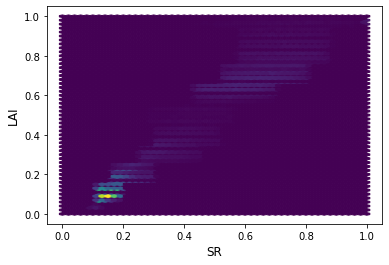

In [245]:

trimSample = trimDF(samples,'LAI','ISR',[20,80],np.arange(0.0,1.1,0.1),np.arange(0.1,1.1,0.1)*0+0.05)
trimSample = trimDF(samples,'LAI','SR',[20,80],np.arange(0.0,1.1,0.1),np.arange(0.1,1.1,0.1)*0+0.05)
plt.hexbin(samples['SR'],samples['LAI'], gridsize=(50,50), extent=(0,1,0,1))
plt.xlabel('SR',size = 12)
plt.ylabel('LAI',size = 12)
plt.show()
plt.hexbin(trimSample['SR'],trimSample['LAI'], gridsize=(50,50), extent=(0,1,0,1))
plt.xlabel('SR',size = 12)
plt.ylabel('LAI',size = 12)
plt.show()

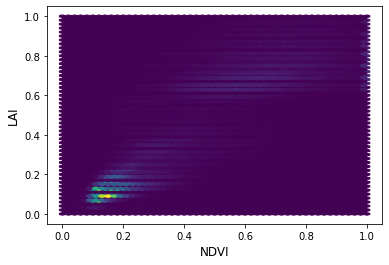

367738
16537
16538
367411


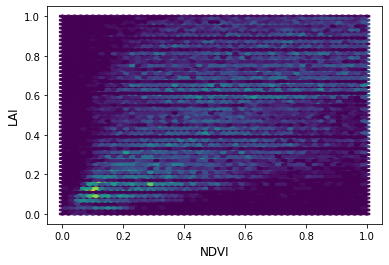

351201
14430
30968
351062


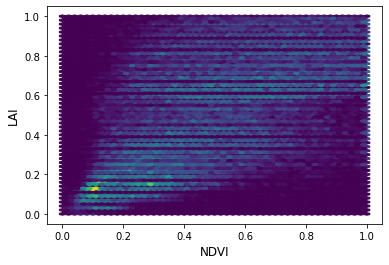

336771
13240
44208
336713


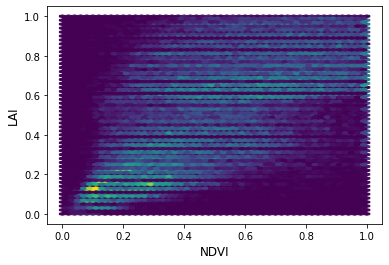

323531
12390
56598
323345


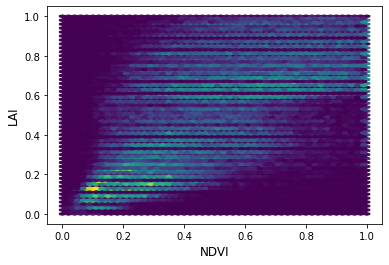

311141
11799
68397
310978


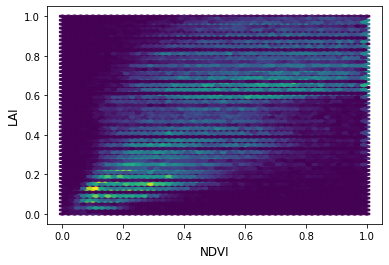

299342
11046
79443
299173


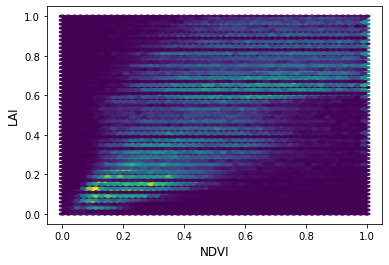

288296
10602
90045
288065


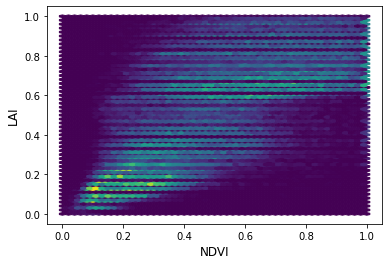

277694
10205
100250
277629


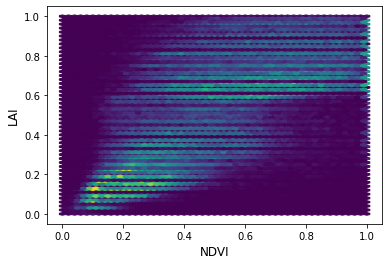

267489
9636
109886
267308


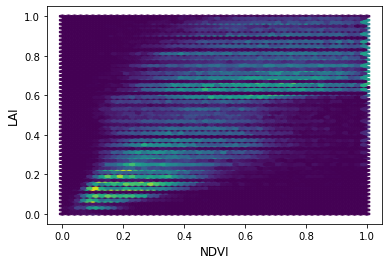

In [112]:
#print(samples)    
plt.hexbin(samples['NDVI'],samples['LAI'], gridsize=(50,50), extent=(0,1,0,1))
plt.xlabel('NDVI',size = 12)
plt.ylabel('LAI',size = 12)
plt.show()
newsamples  = samples.iloc[0:1]
for i in range(1,10):
    print(len(samples))
    sobel = scipy.stats.qmc.Sobol(3,seed=i).random_base2(m=17)
    #print(len(sobel))
    sobelTree = scipy.spatial.KDTree(sobel, leafsize=10, compact_nodes=True, copy_data=False, balanced_tree=True, boxsize=None)
    sampleTree = scipy.spatial.KDTree(samples, leafsize=10, compact_nodes=True, copy_data=False, balanced_tree=True, boxsize=None)
    indexes = sobelTree.query_ball_tree(sampleTree, r=2**(-17/3)*3*0.5,p=1)
    indexes = [ele for ele in indexes if ele != []]
    index = []
    for i in range(len(indexes)):
        index.append(indexes[i][0])
    index = list(set(index))
    newsamples = pd.concat([newsamples,samples.iloc[index]])
    print(len(samples.iloc[index]))
    print(len(newsamples))   
    print(len(set([item for sublist in indexes for item in sublist])))
    samples = samples.drop((samples.iloc[index]).index.values)
    plt.hexbin(newsamples['NDVI'],newsamples['LAI'], gridsize=(50,50), extent=(0,1,0,1))
    plt.xlabel('NDVI',size = 12)
    plt.ylabel('LAI',size = 12)
    plt.show()

In [55]:
print(samples.drop((samples.iloc[indexes[0]]).index.values))

              LAI      NDVI
1026626  0.558824  0.851852
1026567  0.617647  0.824468
1026732  0.720588  0.876676
1026566  0.867647  0.877238
1026476  0.705882  0.861878
...           ...       ...
5027085  0.058824  0.372549
5027050  0.058824  0.370518
5027124  0.058824  0.408333
5027122  0.058824  0.367589
5027051  0.058824  0.391635

[367654 rows x 2 columns]


range(0, 8222)
4610


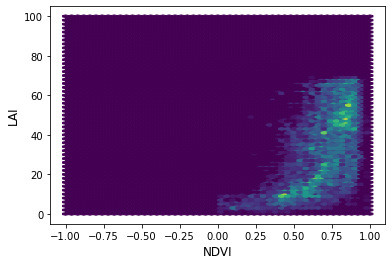

In [56]:

plt.hexbin(sample.iloc[index]['NDVI'],sample.iloc[index]['LAI'], gridsize=(50,50), extent=(-1,1,0,100))
plt.xlabel('NDVI',size = 12)
plt.ylabel('LAI',size = 12)
plt.show()

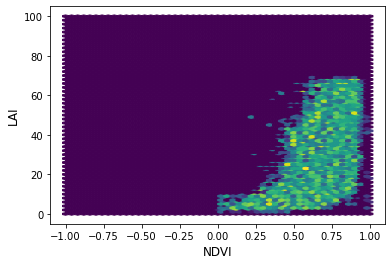

In [ ]:
# remove found matches and resample

In [164]:
# 10 Urban and Built-up Lands: at least 30% impervious surface area including building materials, asphalt and vehicles.

Training_NA_b10 = TrainingDF_NA[(TrainingDF_NA.biome2 == 10)]
Training_NA_b10.shape

(4117, 26)

Text(0, 0.5, 'LAI')

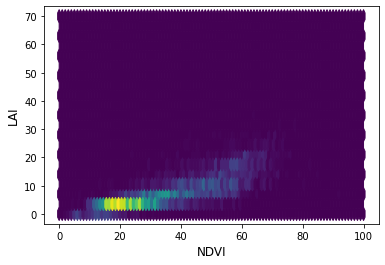

In [203]:
plt.hexbin(Training_NA_b10['NDVI']*100,Training_NA_b10['MCD_LAI']*10, gridsize=(100,10), extent=(0,100,0,70))
plt.xlabel('NDVI',size = 12)
plt.ylabel('LAI',size = 12)

In [209]:
Training_NA_ss = Training_NA_b1s
Training_NA_ss = Training_NA_ss.append(Training_NA_b2s)
Training_NA_ss = Training_NA_ss.append(Training_NA_b3)
Training_NA_ss = Training_NA_ss.append(Training_NA_b4s)
Training_NA_ss = Training_NA_ss.append(Training_NA_b5)
Training_NA_ss = Training_NA_ss.append(Training_NA_b6)
Training_NA_ss = Training_NA_ss.append(Training_NA_b7)
Training_NA_ss = Training_NA_ss.append(Training_NA_b8)
Training_NA_ss = Training_NA_ss.append(Training_NA_b9)
Training_NA_ss = Training_NA_ss.append(Training_NA_b10)
Training_NA_ss.shape

(1959822, 26)

Text(0, 0.5, 'LAI')

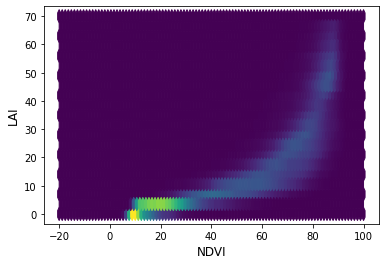

In [210]:
plt.hexbin(Training_NA_ss['NDVI']*100,Training_NA_ss['MCD_LAI']*10, gridsize=(100,10), extent=(-20,100,0,70))
plt.xlabel('NDVI',size = 12)
plt.ylabel('LAI',size = 12)

Text(0, 0.5, 'LAI')

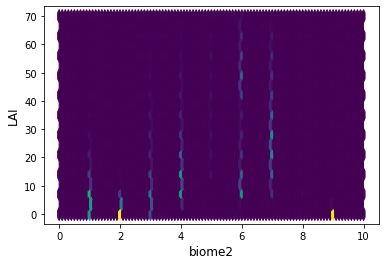

In [211]:
plt.hexbin(Training_NA_ss['biome2'],Training_NA_ss['MCD_LAI']*10, gridsize=(100,10), extent=(0,10,0,70))
plt.xlabel('biome2',size = 12)
plt.ylabel('LAI',size = 12)

Text(0, 0.5, 'Frequency')

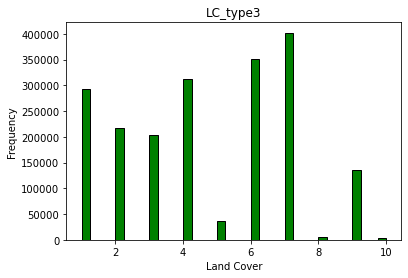

In [212]:
# matplotlib histogram
plt.hist(Training_NA_ss['biome2'], color = 'green', edgecolor = 'black',
         bins = int(180/5))

# Add labels
plt.title('LC_type3')
plt.xlabel('Land Cover')
plt.ylabel('Frequency')

In [213]:
Training_NA_ss.to_csv('D:\CumulativeEffect\WP3\LAI_TM\Landsat_LAI_Canada\calibrationData/Training_NA_ss_DF.csv',index=False)

In [216]:
Training_NA_ss = Training_NA_ss.drop(columns=['year', 'month', 'day', 'path', 'row', 'redMODIS', 'nirMODIS', 'stdLAI', 'stdFAPAR','MODISNDVI'])
Training_NA_ss.shape

(1959822, 16)

In [217]:
print (Training_NA_ss.columns.values)

['sensor' 'lat' 'lon' 'green' 'red' 'nir' 'swir1' 'sensor_zenith'
 'sensor_azimuth' 'sun_zenith' 'sun_azimuth' 'biome2' 'MCD_LAI' 'FAPAR'
 'NDVI' 'NDWI']


In [218]:
Training_NA_ss.to_csv('D:\CumulativeEffect\WP3\LAI_TM\Landsat_LAI_Canada\calibrationData/Training_NA_ss.csv',index=False)

In [ ]:



# US training data




In [111]:
UStrainingDF = pd.read_csv('D:\CumulativeEffect\WP3\LAI_TM\Landsat_LAI_Canada\calibrationData/LAI_training.csv')

In [112]:
UStrainingDF.shape

(1604195, 14)

In [227]:
UStrainingDF.head()

,UID,sensor,biome2,MCD_LAI,lat,lon,sun_azimuth,sun_zenith,NDVI,NDWI,red,green,nir,swir1
0,N03979375000_W08188778050_LT05_018032_20080802,LT05,1,6.1,39.793750,-81.887780,129.339478,31.344311,0.829074,0.392003,376.545824,561.539297,4029.393401,1759.954316
1,S09386273853_E03581939814_LT05_026035_20081029,LT05,1,1.1,35.819398,-93.862739,154.326981,53.620937,0.557919,0.025505,490.055846,417.139419,1726.986905,1641.083786
2,N03483958333_W09545837966_LT05_026036_20061008,LT05,1,2.4,34.839583,-95.458380,151.626495,44.648842,0.703671,0.204043,491.990518,548.012096,2828.578005,1869.889793
3,N04447708333_W08531809532_LT05_022029_20111010,LT05,1,1.0,44.477083,-85.318095,157.022171,53.943436,0.484336,0.025633,724.913509,544.729829,2086.660662,1982.358959
4,N04423958333_W08592677628_LT05_022029_20080424,LT05,1,0.8,44.239583,-85.926776,143.671448,36.254894,0.266392,-0.219365,1250.938623,995.389392,2159.436724,3373.074714


<AxesSubplot:ylabel='Density'>

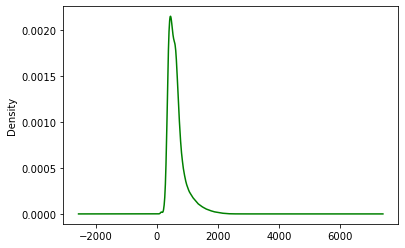

In [31]:
UStrainingDF.green.plot.density(color='green')

<AxesSubplot:ylabel='Density'>

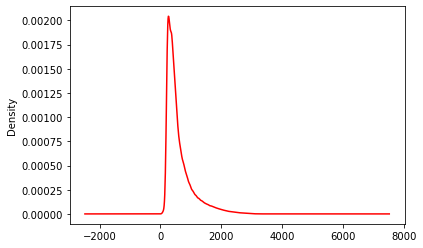

In [32]:
UStrainingDF.red.plot.density(color='red')

<AxesSubplot:ylabel='Density'>

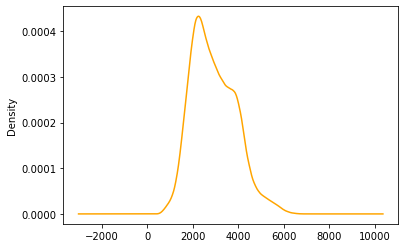

In [35]:
UStrainingDF.nir.plot.density(color='orange')

<AxesSubplot:ylabel='Density'>

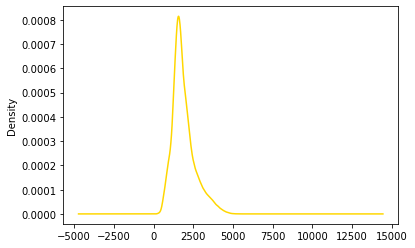

In [37]:
UStrainingDF.swir1.plot.density(color='gold')

<AxesSubplot:ylabel='Density'>

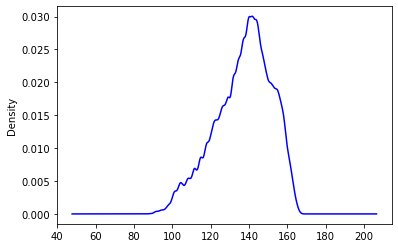

In [38]:
UStrainingDF.sun_azimuth.plot.density(color='blue')

<AxesSubplot:ylabel='Density'>

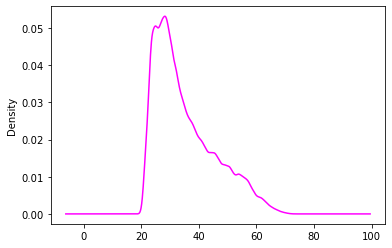

In [39]:
UStrainingDF.sun_zenith.plot.density(color='magenta')

In [114]:
print (UStrainingDF.columns.values)

['UID' 'sensor' 'biome2' 'MCD_LAI' 'lat' 'lon' 'sun_azimuth' 'sun_zenith'
 'NDVI' 'NDWI' 'red' 'green' 'nir' 'swir1']


Text(0, 0.5, 'Frequency')

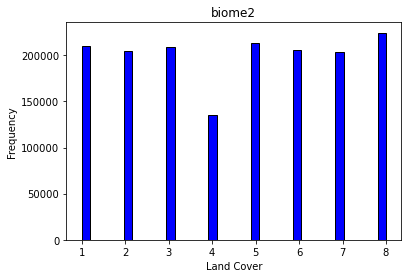

In [18]:
# matplotlib histogram
plt.hist(UStrainingDF['biome2'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

# Add labels
plt.title('biome2')
plt.xlabel('Land Cover')
plt.ylabel('Frequency')

<AxesSubplot:xlabel='biome2', ylabel='MCD_LAI'>

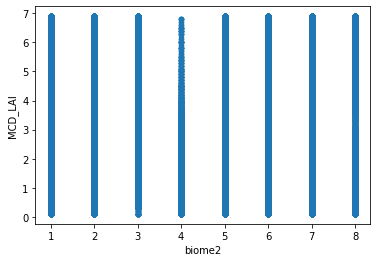

In [228]:
UStrainingDF.plot.scatter('biome2','MCD_LAI')

Text(0, 0.5, 'LAI')

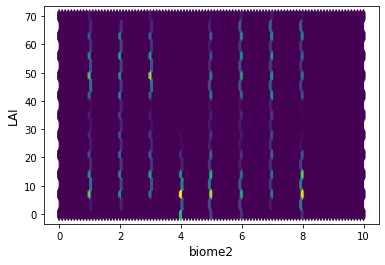

In [229]:
plt.hexbin(UStrainingDF['biome2'],UStrainingDF['MCD_LAI']*10, gridsize=(100,10), extent=(0,10,0,70))
plt.xlabel('biome2',size = 12)
plt.ylabel('LAI',size = 12)

Text(0, 0.5, 'NDWI')

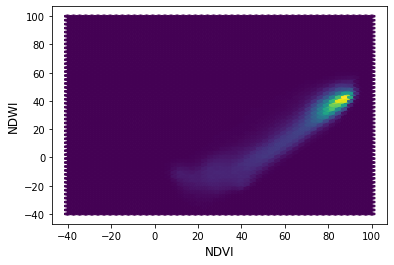

In [116]:
plt.hexbin(UStrainingDF['NDVI']*100,UStrainingDF['NDWI']*100, gridsize=(50,50), extent=(-40,100,-40,100))
plt.xlabel('NDVI',size = 12)
plt.ylabel('NDWI',size = 12)

Text(0, 0.5, 'LAI')

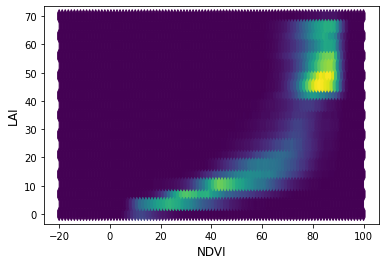

In [8]:
plt.hexbin(UStrainingDF['NDVI']*100,UStrainingDF['MCD_LAI']*10, gridsize=(100,10), extent=(-20,100,0,70))
plt.xlabel('NDVI',size = 12)
plt.ylabel('LAI',size = 12)

Text(0, 0.5, 'LAI')

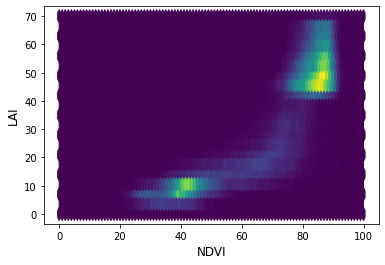

In [221]:
# 1 - Deciduous Forest
UStrainingDF_b1 = UStrainingDF[(UStrainingDF.biome2 == 1)]
plt.hexbin(UStrainingDF_b1['NDVI']*100,UStrainingDF_b1['MCD_LAI']*10, gridsize=(100,10), extent=(0,100,0,70))
plt.xlabel('NDVI',size = 12)
plt.ylabel('LAI',size = 12)

Text(0, 0.5, 'LAI')

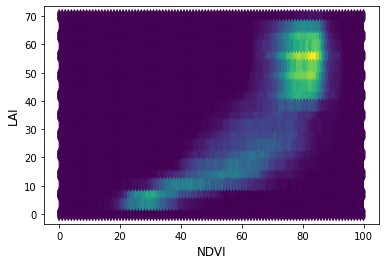

In [222]:
# 2 - Evergreen Forest
UStrainingDF_b2 = UStrainingDF[(UStrainingDF.biome2 == 2)]
plt.hexbin(UStrainingDF_b2['NDVI']*100,UStrainingDF_b2['MCD_LAI']*10, gridsize=(100,10), extent=(0,100,0,70))
plt.xlabel('NDVI',size = 12)
plt.ylabel('LAI',size = 12)

Text(0, 0.5, 'LAI')

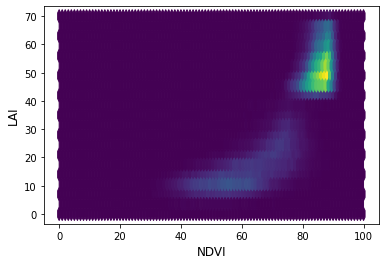

In [223]:
# 3 - Mixed Forest
UStrainingDF_b3 = UStrainingDF[(UStrainingDF.biome2 == 3)]
plt.hexbin(UStrainingDF_b3['NDVI']*100,UStrainingDF_b3['MCD_LAI']*10, gridsize=(100,10), extent=(0,100,0,70))
plt.xlabel('NDVI',size = 12)
plt.ylabel('LAI',size = 12)

Text(0, 0.5, 'LAI')

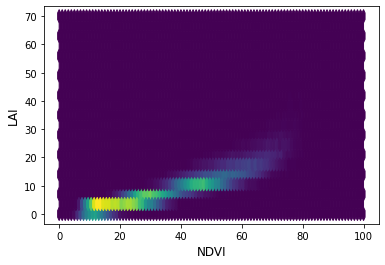

In [224]:
# 4 - Shrubland
UStrainingDF_b4 = UStrainingDF[(UStrainingDF.biome2 == 4)]
plt.hexbin(UStrainingDF_b4['NDVI']*100,UStrainingDF_b4['MCD_LAI']*10, gridsize=(100,10), extent=(0,100,0,70))
plt.xlabel('NDVI',size = 12)
plt.ylabel('LAI',size = 12)

Text(0, 0.5, 'LAI')

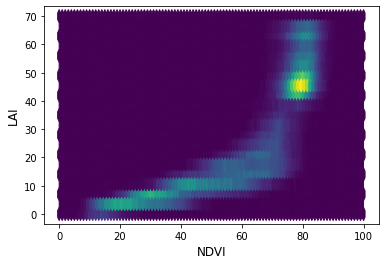

In [225]:
# 5 - Grassland/Pasture
UStrainingDF_b5 = UStrainingDF[(UStrainingDF.biome2 == 5)]
plt.hexbin(UStrainingDF_b5['NDVI']*100,UStrainingDF_b5['MCD_LAI']*10, gridsize=(100,10), extent=(0,100,0,70))
plt.xlabel('NDVI',size = 12)
plt.ylabel('LAI',size = 12)

Text(0, 0.5, 'LAI')

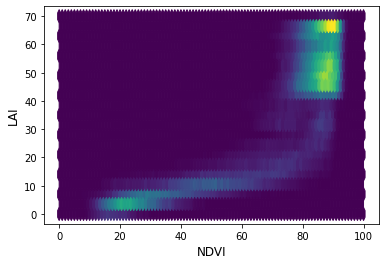

In [235]:
# 6 - Cropland
UStrainingDF_b6 = UStrainingDF[(UStrainingDF.biome2 == 6)]
plt.hexbin(UStrainingDF_b6['NDVI']*100,UStrainingDF_b6['MCD_LAI']*10, gridsize=(100,10), extent=(0,100,0,70))
plt.xlabel('NDVI',size = 12)
plt.ylabel('LAI',size = 12)

Text(0, 0.5, 'LAI')

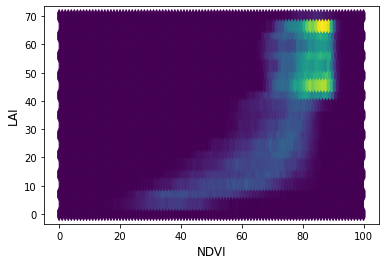

In [236]:
# 7 - Woody Wetland
UStrainingDF_b7 = UStrainingDF[(UStrainingDF.biome2 == 7)]
plt.hexbin(UStrainingDF_b7['NDVI']*100,UStrainingDF_b7['MCD_LAI']*10, gridsize=(100,10), extent=(0,100,0,70))
plt.xlabel('NDVI',size = 12)
plt.ylabel('LAI',size = 12)

Text(0, 0.5, 'LAI')

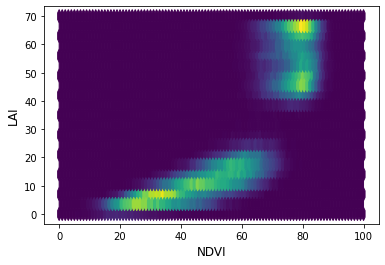

In [237]:
# 8 - Herbaceous Wetland
UStrainingDF_b8 = UStrainingDF[(UStrainingDF.biome2 == 8)]
plt.hexbin(UStrainingDF_b8['NDVI']*100,UStrainingDF_b8['MCD_LAI']*10, gridsize=(100,10), extent=(0,100,0,70))
plt.xlabel('NDVI',size = 12)
plt.ylabel('LAI',size = 12)

Text(0, 0.5, 'Frequency')

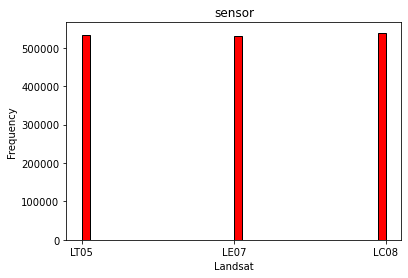

In [238]:
# matplotlib histogram
plt.hist(UStrainingDF['sensor'], color = 'red', edgecolor = 'black',
         bins = int(180/5))

# Add labels
plt.title('sensor')
plt.xlabel('Landsat')
plt.ylabel('Frequency')